**Imagehash** を使って Train と Test のデータに重複がないかを確認しました。  
類似した画像は Train/Test のどちらか一方だけに含まれることが多かったが、一部 Train と Test で分かれているものもありました（人の目には似てないように見えるものも多々ありますが）。何かの参考になれば幸いです。  


- 参考にしたノートブック: https://www.kaggle.com/appian/let-s-find-out-duplicate-images-with-imagehash

In [ ]:
!pip install imagehash > /dev/null

In [2]:
import os
from dataclasses import dataclass
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image


%matplotlib inline
sns.set_style("whitegrid")

In [3]:
@dataclass
class InputPath:
    _prefix: str = "../input/"
    photo_prefix: str = f"{_prefix}/photos"
    train: str = f"{_prefix}/train.csv"
    test: str = f"{_prefix}/test.csv"
        
        
def load_csv(path: str) -> pd.DataFrame:
    return pd.read_csv(path)


def get_image_path(object_id: str) -> str:
    return os.path.join(InputPath.photo_prefix, f"{object_id}.jpg")


def read_image(object_id: str) -> np.array:
    path = get_image_path(object_id)
    im = Image.open(path)
    im_array = np.asarray(im)
    return im_array

### Imagehash

In [4]:
import torch
import imagehash
from tqdm import tqdm


def run_imagehash(df: pd.DataFrame) -> Tuple[List[str], np.array]:
    funcs = [
        imagehash.average_hash,
        imagehash.phash,
        imagehash.dhash,
        imagehash.whash,
    ]
    object_ids: List[str] = []
    hashes: List[np.array] = []
    for object_id in tqdm(set(df["object_id"].values.tolist())):
        path = get_image_path(object_id)
        image = Image.open(path)
        hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))
        object_ids.append(object_id)
    return object_ids, np.array(hashes)


train = load_csv(InputPath.train)
test = load_csv(InputPath.test)
train_test = pd.concat((train, test), axis=0, ignore_index=True)
%time object_ids, hashes_all = run_imagehash(train_test)

100%|██████████| 9856/9856 [00:30<00:00, 326.62it/s]


CPU times: user 30.1 s, sys: 142 ms, total: 30.3 s
Wall time: 30.2 s


In [5]:
hashes_all = torch.Tensor(hashes_all.astype(int)).cuda()
sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).cpu().numpy()/256 for i in range(hashes_all.shape[0])])

In [6]:
threhold = 0.89

indices1 = np.where(sims > threhold)
indices2 = np.where(indices1[0] != indices1[1])
object_ids1 = [object_ids[i] for i in indices1[0][indices2]]
object_ids2 = [object_ids[i] for i in indices1[1][indices2]]
dups = {tuple(sorted([object_id1, object_id2])):True for object_id1, object_id2 in zip(object_ids1, object_ids2)}
print(f'found {len(dups)} duplicates')

found 42 duplicates


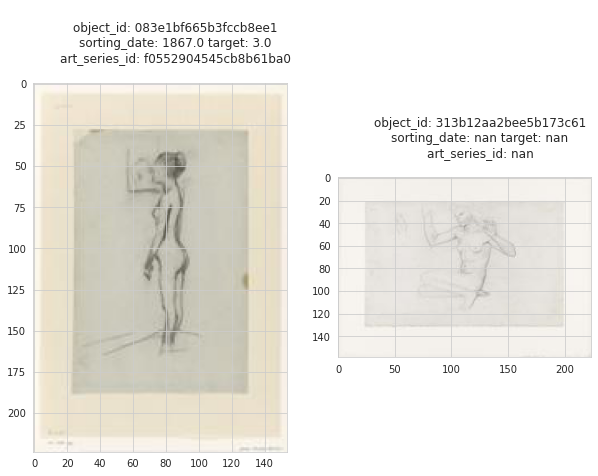

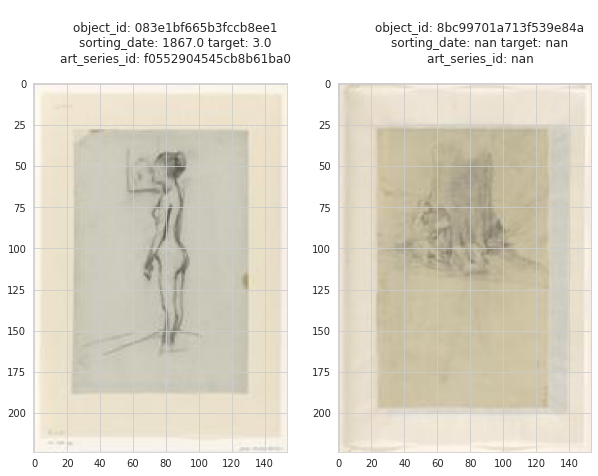

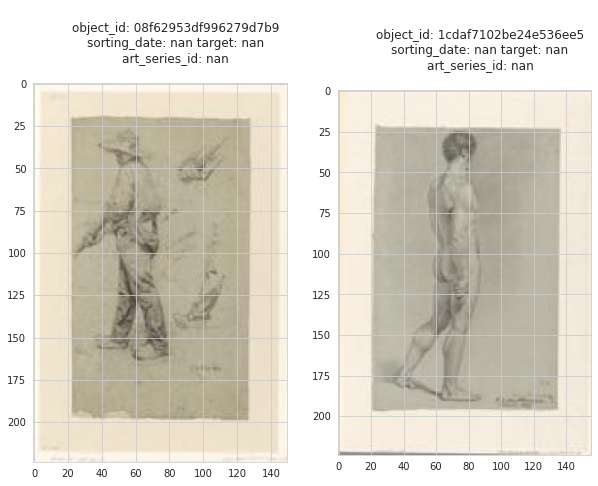

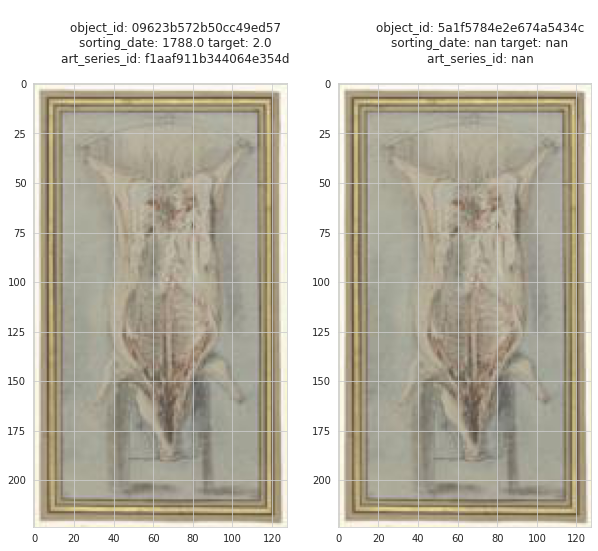

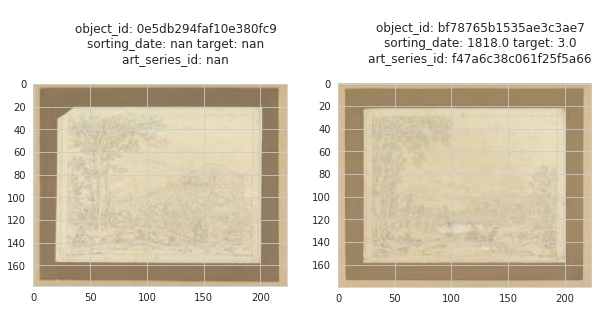

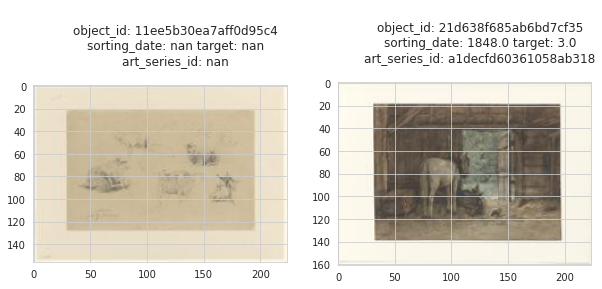

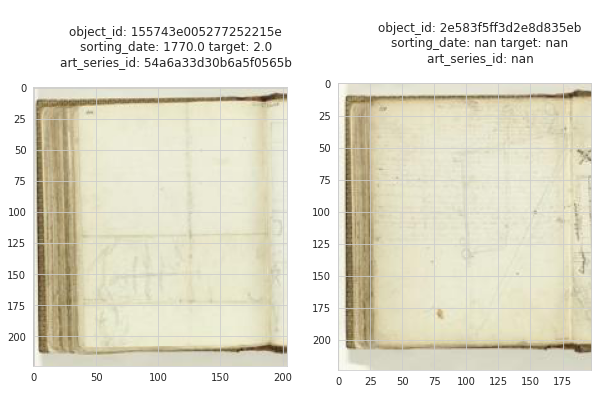

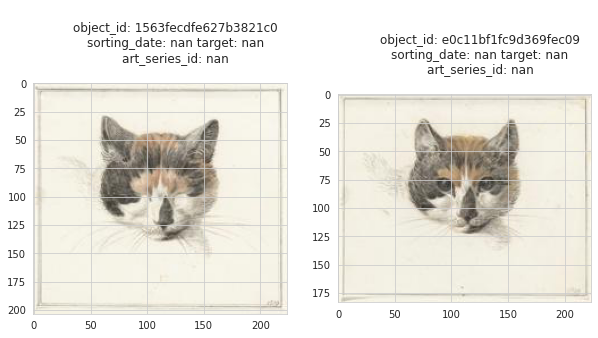

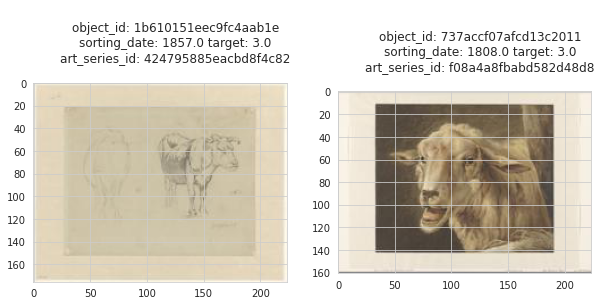

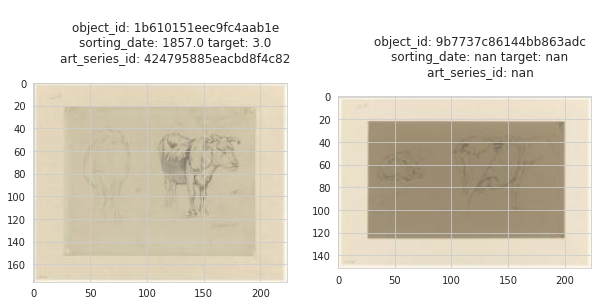

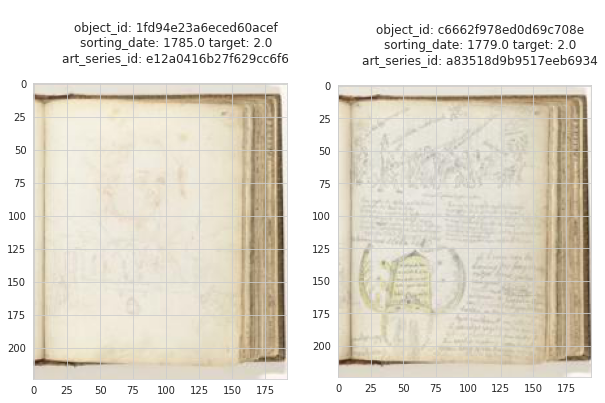

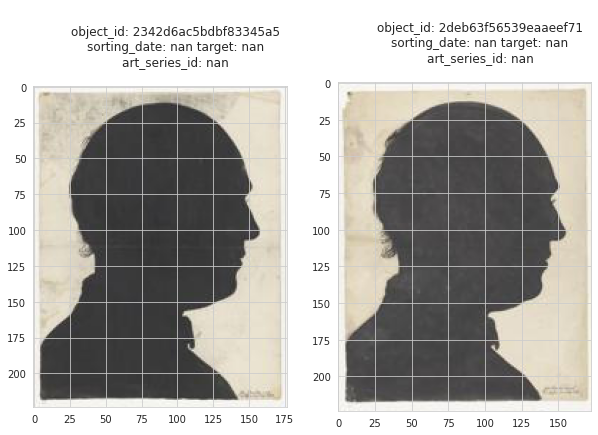

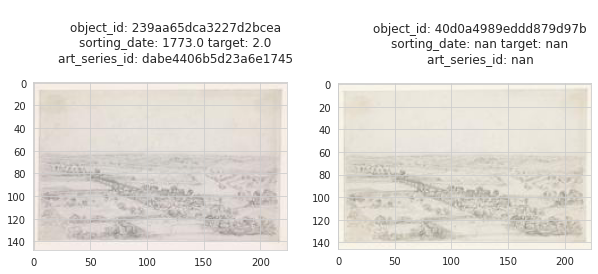

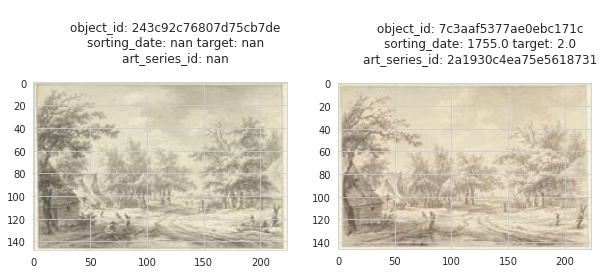

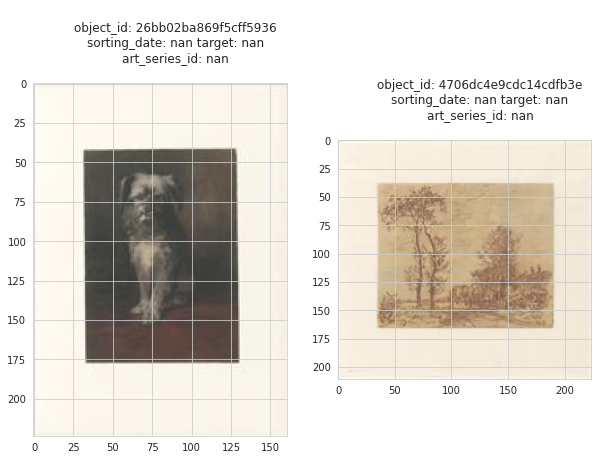

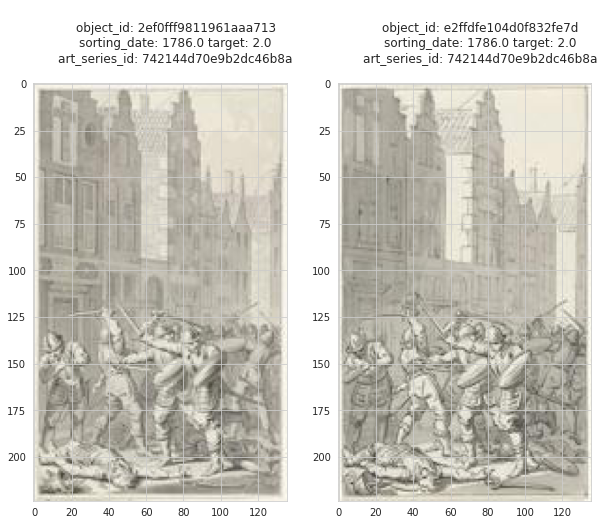

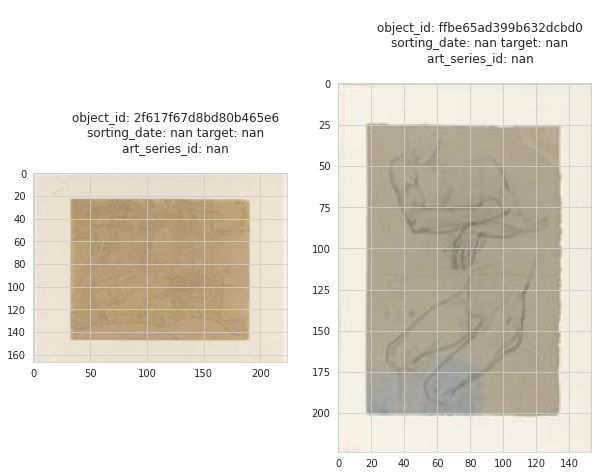

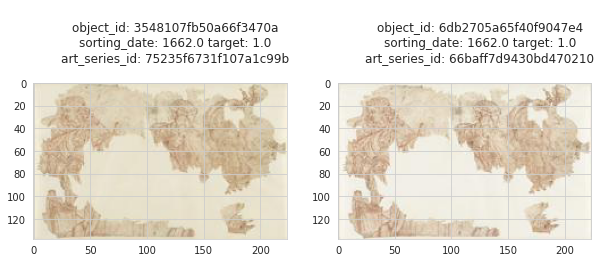

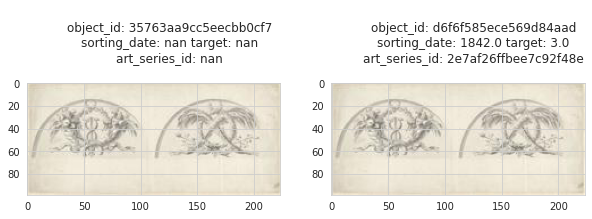

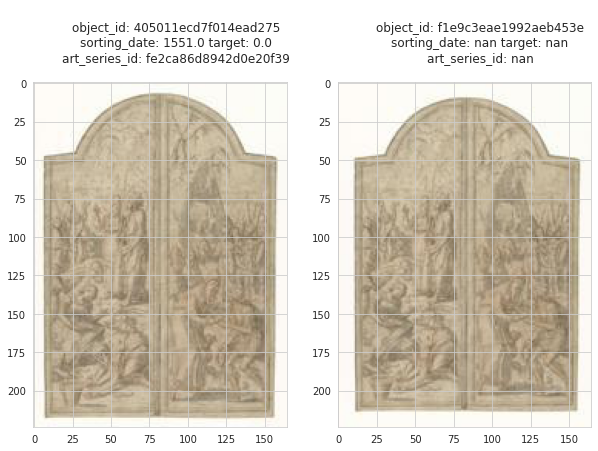

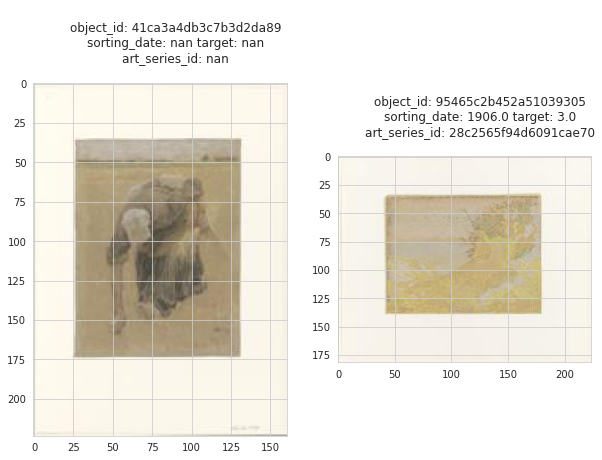

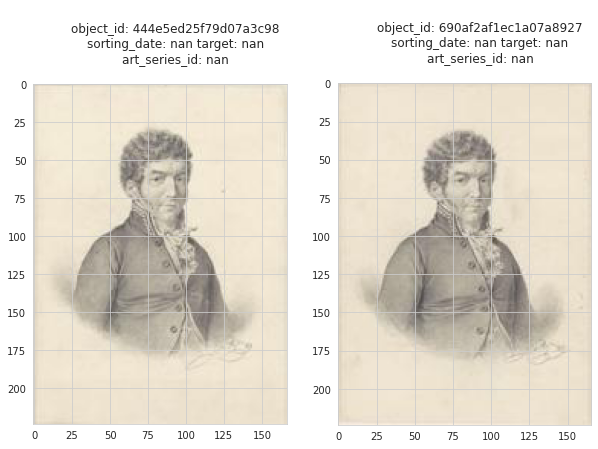

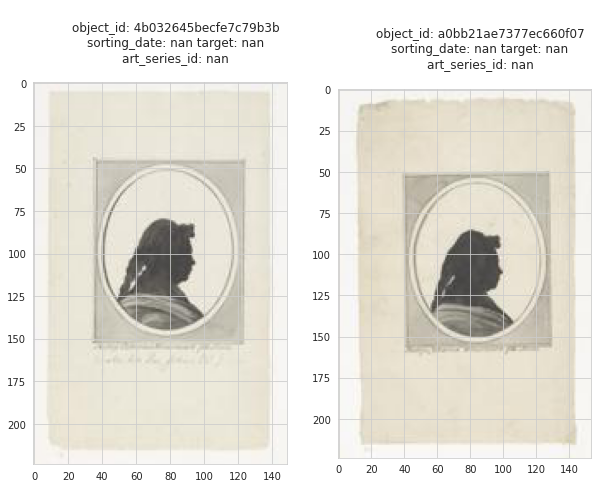

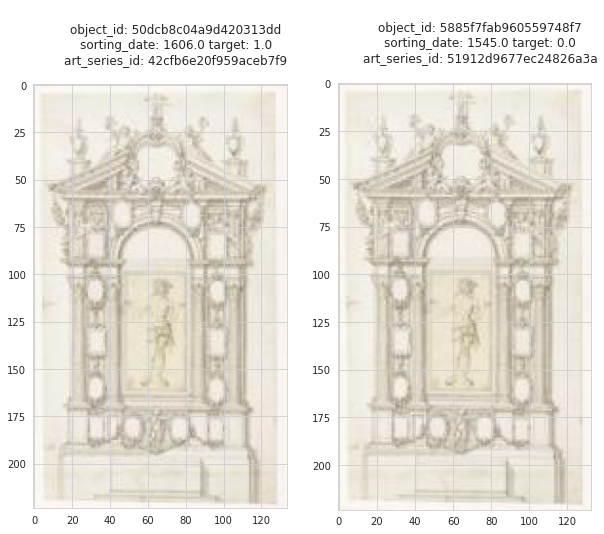

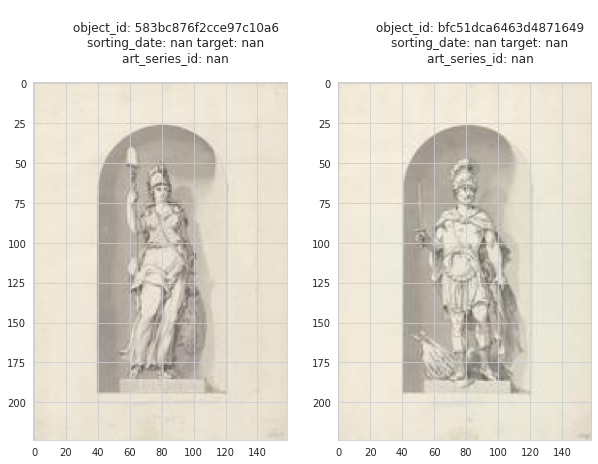

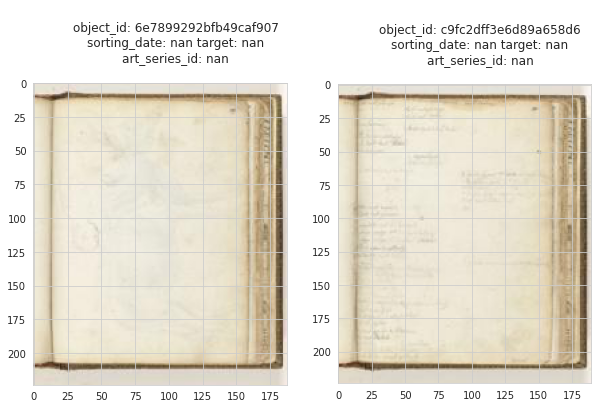

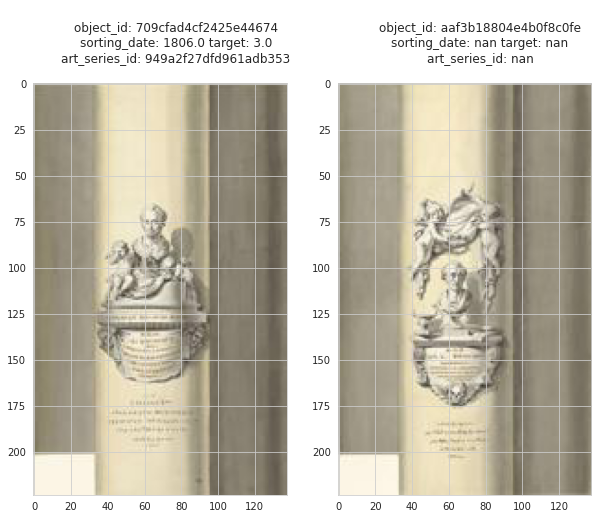

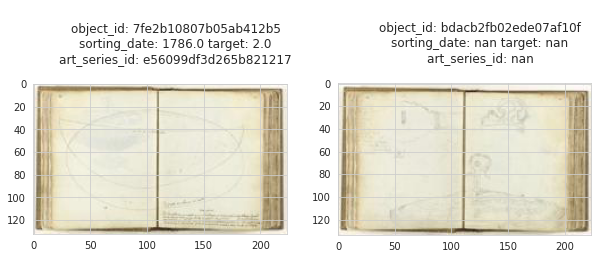

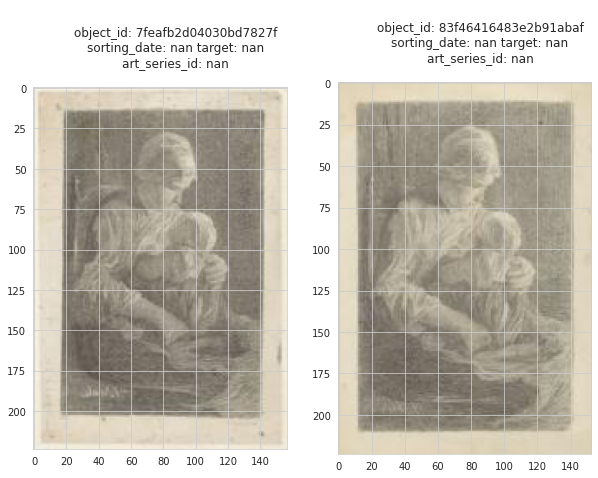

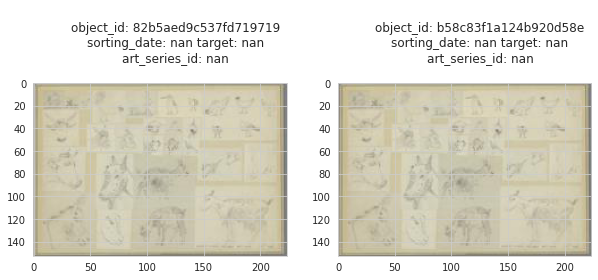

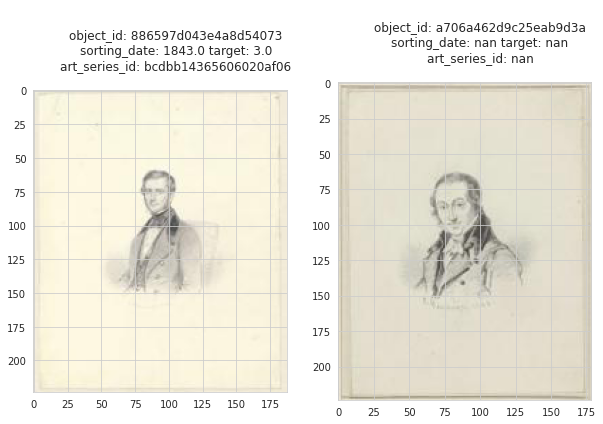

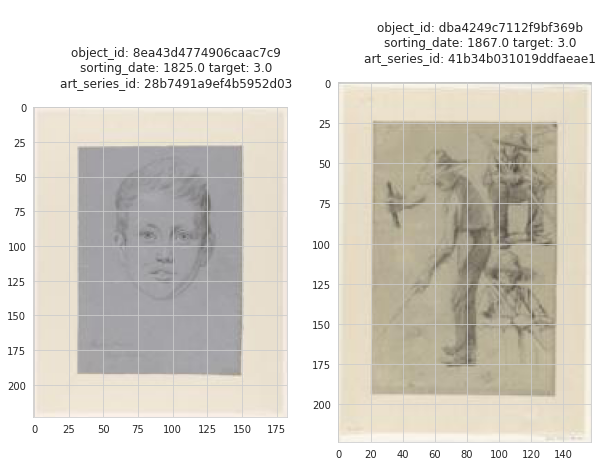

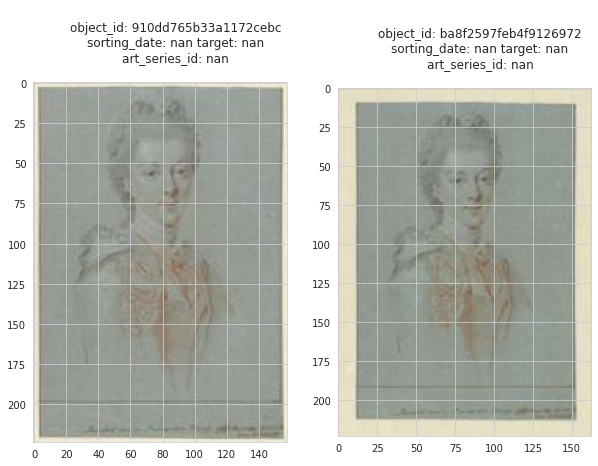

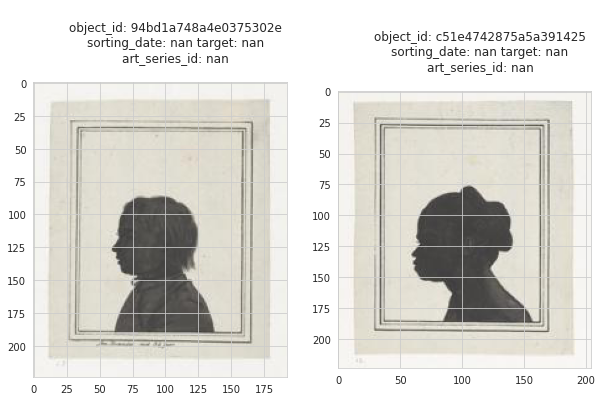

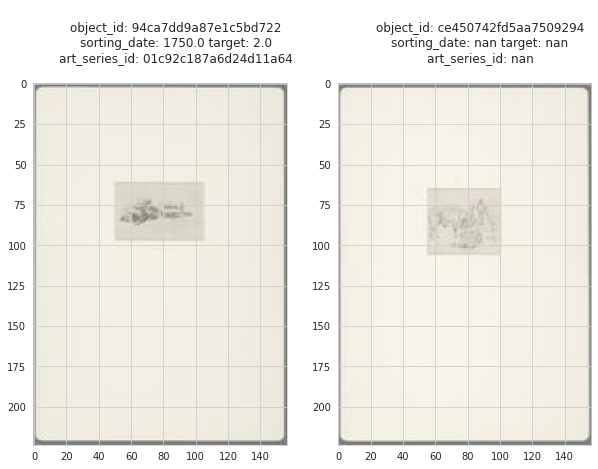

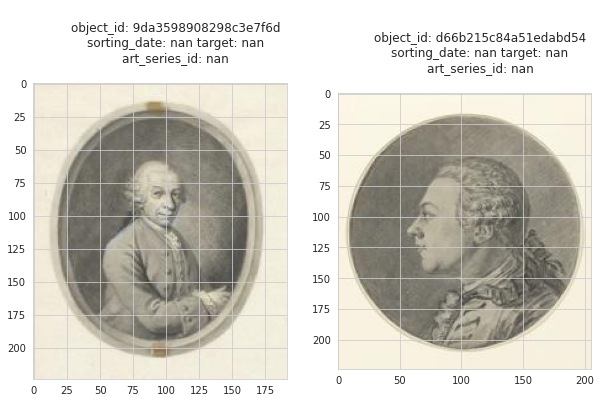

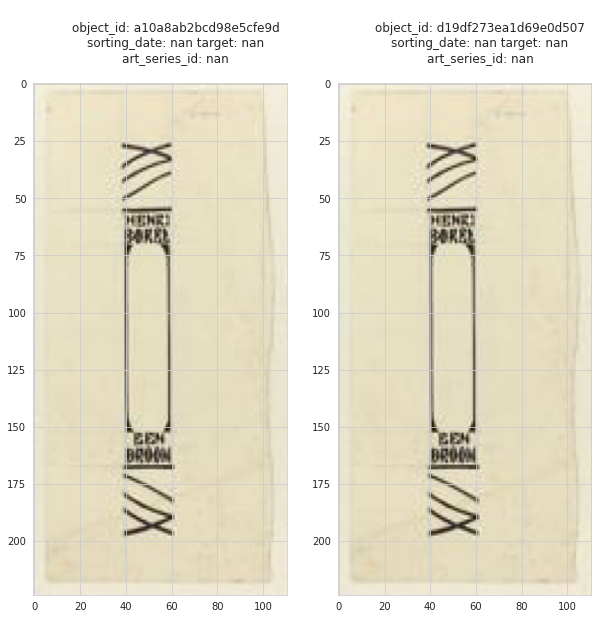

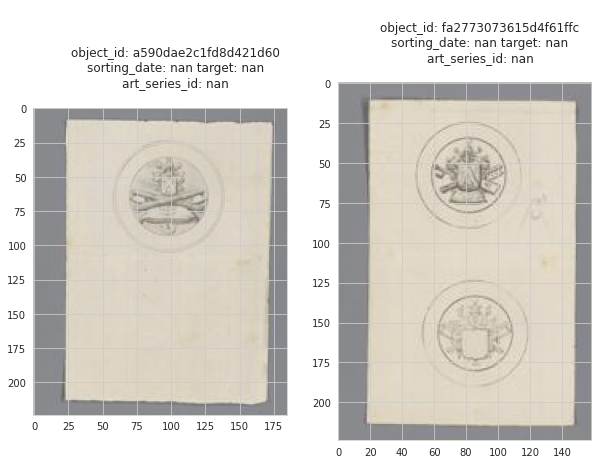

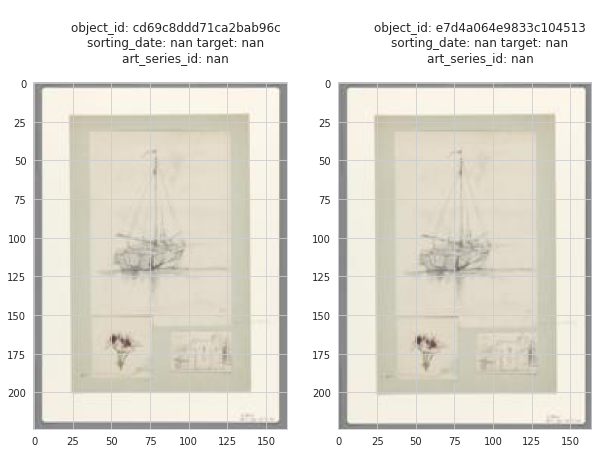

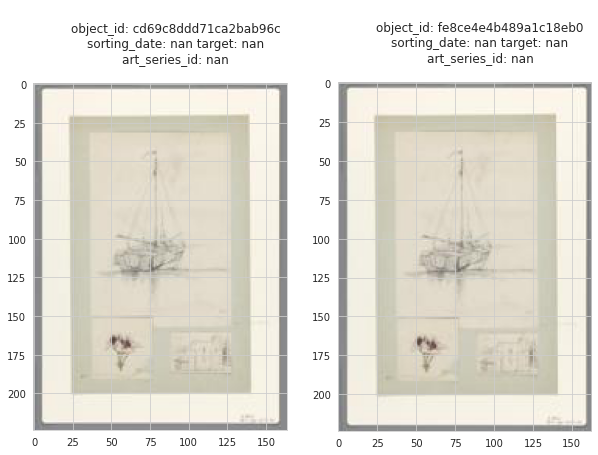

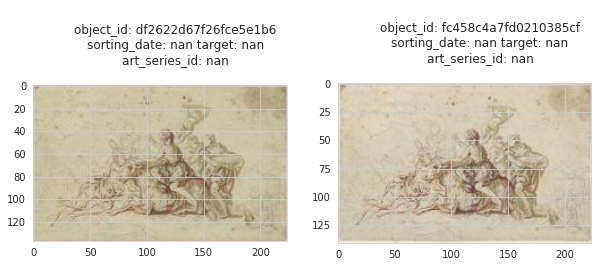

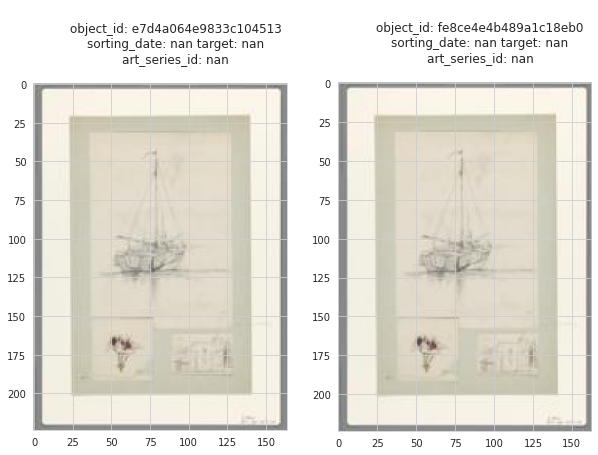

In [7]:
for object_id1, object_id2 in sorted(list(dups)):
    row1 = train_test[train_test["object_id"]==object_id1]
    row2 = train_test[train_test["object_id"]==object_id2]
    
    fig = plt.figure(figsize=(10, 20))
    fig.add_subplot(1,2,1)
    plt.title(f"""
        object_id: {row1['object_id'].iloc[0]}
        sorting_date: {row1['sorting_date'].iloc[0]} target: {row1['target'].iloc[0]}
        art_series_id: {row1['art_series_id'].iloc[0]}
    """)
    plt.imshow(read_image(object_id1))
    fig.add_subplot(1,2,2)
    plt.title(f"""
        object_id: {row2['object_id'].iloc[0]}
        sorting_date: {row2['sorting_date'].iloc[0]} target: {row2['target'].iloc[0]}
        art_series_id: {row2['art_series_id'].iloc[0]}
    """)
    plt.imshow(read_image(object_id2))
    plt.show()